[EMアルゴリズム徹底解説 \- Qiita](https://qiita.com/kenmatsu4/items/59ea3e5dfa3d4c161efb)

[Qiita\_Contents/Gaussian\_mixture\_demo\-automate\-animate\.ipynb at master · matsuken92/Qiita\_Contents](https://github.com/matsuken92/Qiita_Contents/blob/master/EM_Algorithm/Gaussian_mixture_demo-automate-animate.ipynb)

In [1]:
import numpy
import scipy
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["patch.force_edgecolor"] = True
import seaborn
seaborn.set_style("whitegrid", {'grid.linestyle': '--'})

## create data

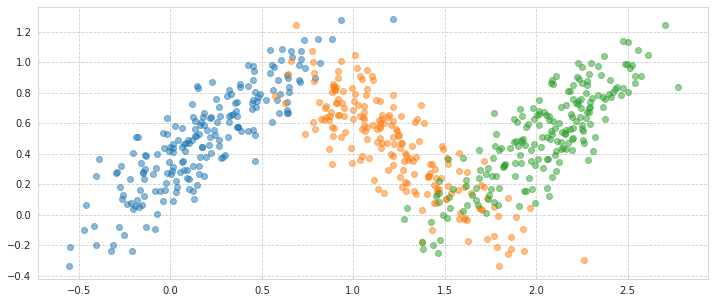

In [2]:
mu_true = numpy.array(
    [
        [0.2, 0.5],
        [1.2, 0.5],
        [2.0, 0.5],
    ]
)
sigma_true = numpy.array(
    [
        [[0.1, 0.085], [0.085, 0.1],],
        [[0.1, -0.085], [-0.085, 0.1],],
        [[0.1, 0.085], [0.085, 0.1],],
    ]
)

org_data = [
    scipy.stats.multivariate_normal.rvs(mean=mu, cov=sigma, size=200) for mu, sigma in zip(mu_true, sigma_true)
]

plt.figure(figsize=(12, 5))
for d in org_data:
    plt.scatter(x=d[:, 0], y=d[:, 1], alpha=0.5)

# Initialize

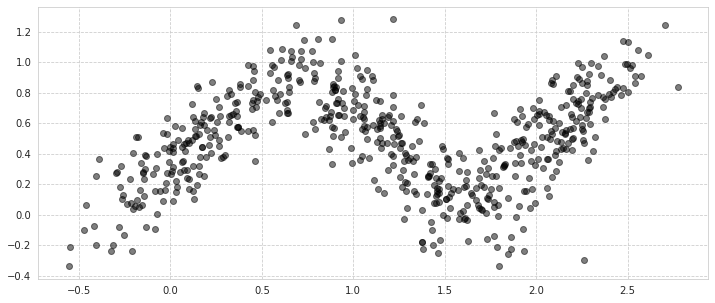

In [3]:
data = numpy.concatenate(org_data)

plt.figure(figsize=(12, 5))
plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.5, c='black')

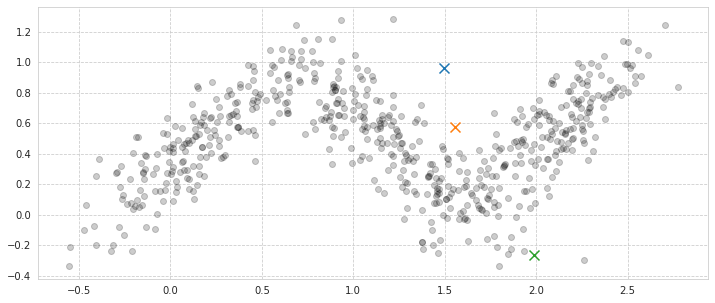

In [4]:
NUMBER_OF_CLUSTERS = 3

mu = numpy.random.uniform(low=data.min(axis=0), high=data.max(axis=0), size=(NUMBER_OF_CLUSTERS, data.shape[1]))

sigma = numpy.array([
    [[0.1, 0], [0, 0.1]],
    [[0.1, 0], [0, 0.1]],
    [[0.1, 0], [0, 0.1]],
])

plt.figure(figsize=(12, 5))
for m in mu:
    plt.scatter(x=m[0], y=m[1], marker='x', s=100)
plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.2, c='black')

# EM algorithm
- $n$: number of data
- $k$: number of clusters
- $z_{nk}$: latent variable where the datum belongs
- $\gamma(z_{nk})$: responsibility
- 
## E-step


In [5]:
import numpy.typing
import dataclasses

from logging import getLogger, StreamHandler, DEBUG, INFO, WARNING,Logger
logger = getLogger(__name__)
handler = StreamHandler()
handler.setLevel(WARNING)
logger.setLevel(DEBUG)
logger.addHandler(handler)
logger.propagate = False

@dataclasses.dataclass
class EM_Algorithm:
    """
    k: number of clusters
    n: number of data
    d: dimension of a datum

    - Attributes
        - NUMBER_OF_CLUSTERS: int
        - mu: ArrayLike[k, d]           means of each normals
        - sigma: ArrayLike[k, d, d]     variances of each normals
        - pi: ArrayLike[k]              responsivility of each multivariant-normals
        - gamma: ArrayLike[k, n]        
    """
    NUMBER_OF_CLUSTERS: int
    mu: numpy.typing.ArrayLike
    sigma: numpy.typing.ArrayLike
    logger: Logger = logger

    def __post_init__(self):
        assert self.NUMBER_OF_CLUSTERS is not None

        assert self.mu.shape[0] == self.NUMBER_OF_CLUSTERS

        assert self.sigma.shape[0] == self.NUMBER_OF_CLUSTERS
        assert self.sigma.shape[1:] == (self.mu.shape[1], self.mu.shape[1])

        self.pi = numpy.ones(self.NUMBER_OF_CLUSTERS)/self.NUMBER_OF_CLUSTERS
        

    def likelihood(self, data):
        """return likelihood as an ArrayLike[k, n]

        multivariate_normal should return 0 < p < 1 ...?
        """
        return numpy.stack(
            [p * scipy.stats.multivariate_normal.pdf(data, m, s) for p, m, s in zip(self.pi, self.mu, self.sigma)]
        )

    def e_step(self, data):
        e_likelihood = self.likelihood(data)
        self.logger.debug('e_likelihood.shape: {}'.format(e_likelihood.shape))

        self.gamma = e_likelihood / e_likelihood.sum(axis=0, keepdims=True)
        self.logger.debug('gamma.shape: {}'.format(self.gamma.shape))
        return self.gamma
    
    def m_step(self, data):
        """
        pi = \sum_n$\gamma$(z_{nk})/n

        """
        self.pi = self.gamma.sum(axis=1) / len(data)
        self.logger.debug('pi.shape: {}'.format(self.pi.shape))

#        self.sigma = self.gamma.dot(numpy.stack(
#                [(data-m).T.dot(data-m) for m in self.mu]
#        )).sum(axis=1) / self.gamma.sum(axis=1, keepdims=True)
        self.sigma = numpy.stack([
            numpy.array([
                g * numpy.outer(d - m, d - m) for g, d in zip(gk, data)
            ]).sum(axis=0) / Nk
            for m, gk, Nk in zip(self.mu, self.gamma, self.gamma.sum(axis=1))
        ])
        self.logger.debug('sigma.shape: {}'.format(self.sigma.shape))

        self.mu = self.gamma.dot(data) / self.gamma.sum(axis=1, keepdims=True)
        self.logger.debug('mu.shape: {}'.format(self.mu.shape))

In [6]:
em = EM_Algorithm(NUMBER_OF_CLUSTERS, mu, sigma)
sum_log = lambda l: numpy.sum(numpy.log(l))
prev_sumlog_likelihood = sum_log(em.likelihood(data))

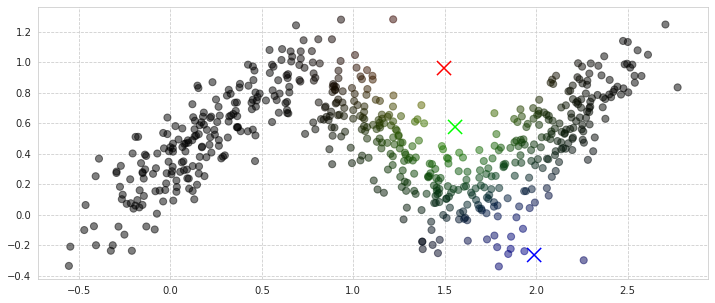

In [7]:
fig = plt.figure(figsize=(12, 5))
_ = plt.scatter(x=em.mu[:, 0], y=em.mu[:, 1], marker='x', color=(numpy.eye(3)), s=200)
_ = plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.5, color=numpy.clip(em.likelihood(data).T, 0, 1), s=50)
plt.show()

In [8]:
fig = plt.figure(figsize=(12, 5))
artists = []

for i in range(20):
    logger.info("loop: {}".format(i))
    _ = em.e_step(data)
    _ = em.m_step(data)

    # 
    logger.info("pi: {}, sum={}".format(em.pi, em.pi.sum()))
    logger.info("mu:\n{}".format(em.mu))
    logger.info("sigma:\n{}".format(em.sigma))
    logger.info("gamma: {}, sum={}".format(em.gamma.sum(axis=1), em.gamma.sum()))

    # check convergence
    likelihood = em.likelihood(data)
    sumlog_likelihood = sum_log(likelihood)
    logger.info("likelihood: {} -> {:.4f}".format(prev_sumlog_likelihood, sumlog_likelihood))

    # plot progress
    mu_plot = plt.scatter(x=em.mu[:, 0], y=em.mu[:, 1], marker='x', color=(numpy.eye(3)), s=200)
    data_plot = plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.5, color=numpy.clip(likelihood.T, 0, 1))
    #title = plt.title("iter={}, convergence={}".format(i, prev_sumlog_likelihood - sumlog_likelihood))
    title = plt.text(
        x=data[:, 0].mean(), y=data[:, 1].max()+0.2,
        s="iter={}, convergence={}".format(i, prev_sumlog_likelihood - sumlog_likelihood),
        horizontalalignment='center', verticalalignment='bottom', size=20
    )
    artists.append([mu_plot, data_plot, title])

    if abs(prev_sumlog_likelihood - sumlog_likelihood) < 1e-4:
        break
    prev_sumlog_likelihood = sumlog_likelihood

plt.close()

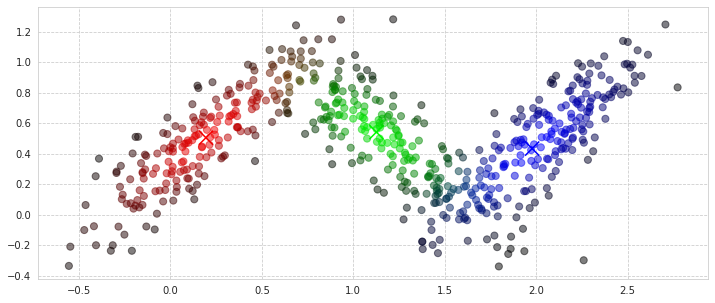

In [10]:
fig = plt.figure(figsize=(12, 5))
_ = plt.scatter(x=em.mu[:, 0], y=em.mu[:, 1], marker='x', color=(numpy.eye(3)), s=200)
_ = plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.5, color=numpy.clip(em.likelihood(data).T, 0, 1), s=50)
plt.show()

In [9]:
#%matplotlib inline
#%matplotlib nbagg
import matplotlib.animation
import IPython.display

anim = matplotlib.animation.ArtistAnimation(fig, artists, interval=500)
#anim.save('anim.mp4', writer='ffmpeg')
#anim.save('anim.gif', writer='imagemagick')
IPython.display.HTML(anim.to_jshtml())
